# Week 4: Variational Monte Carlo Method

## Repetition of Monte Carlo method

* Repeated random sampling
* Three main areas: optimization, numerical integration, generating draws from probability distribution
* Useful for systems with many coupled degrees of freedom
* Can in principle solve any problem with a probabilistic interpretation
* High computational cost can be reduced with parallelization

The steps of MC:
1. Define domain of useful inputs (e.g. a unit square)
2. Genereate inputs randomly from a probabilitydistribution over the domain (uniformly scatter points over the square)
3. Perform a deterministic conputation on the inputs (count the number of points that are 1 unit or less from the bottom left corner (inside an inscribed quadrant))
4. Aggregate the results (the ratio of points inside the quadrant and the total number of points represent the ration of the two areas, $\frac{\pi}{4}$, multiply it by 4 to get an estimate of $\pi$)

Challenge: we need a very large amout of points to get a random enough distribution

### Variational Monte Carlo method
* Quantum Monte Carlo method
* Used to approximate the ground state of a quantum system
* Uses the generic wave function, $|\Psi(\mathbf{a})\rangle$, depending on some parameters $\mathbf{a}$ which is optimized when the minimum energy of the system is found

## Quantum Monte Carlo

### Motivation
* Quantum mechanical problems typically consist of a large number of interacting particles
* Often too many for an exact solution to be found
* The expectation value of the Hamiltonian for a system with N particles
$$\langle H\rangle = \frac{\int d\mathbf{R}_1 d\mathbf{R}_2...d\mathbf{R}_N \Psi^*(\mathbf{R}_1, \mathbf{R}_2,..., \mathbf{R}_N)H(\mathbf{R}_1, \mathbf{R}_2,..., \mathbf{R}_N)\Psi(\mathbf{R}_1, \mathbf{R}_2,..., \mathbf{R}_N)}{\int d\mathbf{R}_1 d\mathbf{R}_2...d\mathbf{R}_N \Psi^*(\mathbf{R}_1, \mathbf{R}_2,..., \mathbf{R}_N)\Psi(\mathbf{R}_1, \mathbf{R}_2,..., \mathbf{R}_N)}$$
* Example from nuclear many-body problem: Schrödinger's equation as a differential equation
$$\mathbf{H}\Psi(\mathbf{r}_1,...,\mathbf{r}_A, \alpha_1,...,\alpha_A) = E\Psi(\mathbf{r}_1,...,\mathbf{r}_A, \alpha_1,...,\alpha_A)$$
where $\mathbf{r},...,\mathbf{r}$ are coordinates and $\alpha_1,...,\alpha_A$ are sets of relevant quantum numbers and $A=N+Z$ is the total number of nucleons (neutrons + protons)
* There are 
$$2^A\times\binom{A}{Z}$$
coupled second-order differential equations in 3A dimensions
* When to use:
    * Light atoms, molecules, solids and nuclei
    * Simulations of systems in solid state physics from semiconductors to spin systems, many active electrons and possible strong correlation

| Pros | Cons |
| :- | :- |
| - Physically intuitive | - Statistical error can be large |
| - Can study systems with many degrees of freedom | - Limited how large systems one can study|
| - VMC is easy to implement, but needs a reliable trial wave function | - Will only get the lowest-lying states with a given symmetry |

* The variational principle states that the expectation value of $\langle H\rangle$ is an upper bound to the ground state energy $E_0$ of $H$ (meaning $E_0 \leq \langle H\rangle$) 
* The expectation value of $\langle H\rangle$ is defined through
$$E[H] = \langle H\rangle = \frac{\int d\mathbf{R}\Psi^*_T(\mathbf{R})H(\mathbf{R})\Psi_T(\mathbf{R})}{\int d\mathbf{R}\Psi^*_T(\mathbf{R})\Psi_T(\mathbf{R})}$$
for a given hamiltonian and trial function $\Psi_T$
* $\Psi_T$ can be expanded in the eigenstates of the hamiltonian since they form a complete set
$$\Psi_T(\mathbf{R}) = \sum_i a_i\Psi_i(\mathbf{R}$$
and if we assume that the set of eigenfunctions are normalized, we get
$$\frac{\sum_n a_n^2E_n}{\sum_n a_n^2}\geq E_0$$
* The exact wave function leads to zero variance
* Variation is performed by minimizing both energy and variance

Algorithm for peforming a VMC:
1. Fix the number of MC steps, choose initial $\mathbf{R}$ and variational parameters $\mathbf{\alpha}$, calculate $|\psi_T^{\alpha}(\mathbf{R})|^2$
2. Initialize energy and variance and start the calculation
    - Calculate a trial position $\mathbf{R}_p=\mathbf{R}+r\cdot step$, where $r$ is a random variable $r\in [0,1]$
    - Metropolis algorithm to accept or reject this move, $w=P(\mathbf{R}_p)/P(\mathbf{R})$
    - If accepted, the position is updated, $\mathbf{R}=\mathbf{R}_p$
    - Update averages
3. Finish and compute final averages


## Example: Ground  state of harmonic oscillator

In [3]:
# VMC for the one-dimensional harmonic oscillator
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from decimal import *

# Trial wave function for the Harmonic oscillator in one dimension
def WaveFunction(r,alpha):
    return exp(-0.5*alpha*alpha*r*r)

# Local energy for the Harmonic oscillator in one dimension
def LocalEnergy(r,alpha):
    return 0.5*r*r*(1-alpha**4) + 0.5*alpha*alpha

# The Monte Carlo sampling with the Metropolis algo
# The jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when the function is called.
def MonteCarloSampling():
    NumberMCcycles= 100000
    StepSize = 1.0
    # positions
    PositionOld = 0.0
    PositionNew = 0.0
    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.4
    for ia in range(MaxVariations):
        alpha += .05
        AlphaValues[ia] = alpha
        energy = energy2 = 0.0
        #Initial position
        PositionOld = StepSize * (random() - .5)
        wfold = WaveFunction(PositionOld,alpha)
        #Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            #Trial position
            PositionNew = PositionOld + StepSize*(random() - .5)
            wfnew = WaveFunction(PositionNew,alpha)
            #Metropolis test to see whether we accept the move
            if random() <= wfnew**2 / wfold**2:
                PositionOld = PositionNew
                wfold = wfnew
            DeltaE = LocalEnergy(PositionOld,alpha)
            energy += DeltaE
            energy2 += DeltaE**2
        #We calculate mean, variance and error
        energy /= NumberMCcycles
        energy2 /= NumberMCcycles
        variance = energy2 - energy**2
        error = sqrt(variance/NumberMCcycles)
        Energies[ia] = energy
        Variances[ia] = variance
        #outfile.write('%f %f %f %f \n' %(alpha,energy,variance,error))
    return Energies, AlphaValues, Variances


main():

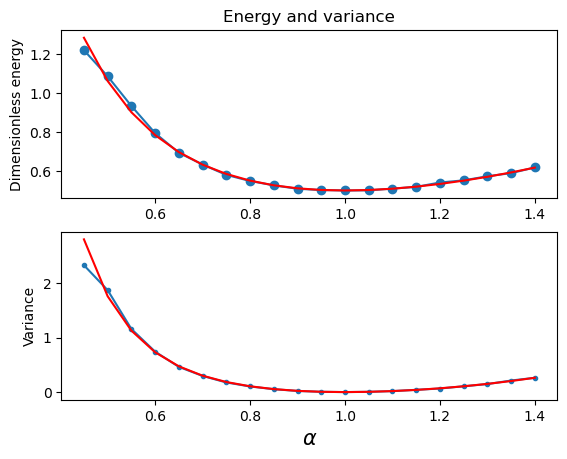

    Alpha    Energy  Exact Energy  Variance  Exact Variance
0    0.45  1.221193      1.285193  2.328457        2.803442
1    0.50  1.086874      1.062500  1.870353        1.757812
2    0.55  0.934315      0.902071  1.158174        1.127465
3    0.60  0.794851      0.784444  0.741769        0.730706
4    0.65  0.693840      0.697341  0.462769        0.472569
5    0.70  0.633449      0.632704  0.296522        0.300629
6    0.75  0.580193      0.585069  0.176748        0.184613
7    0.80  0.548805      0.550625  0.103054        0.106376
8    0.85  0.526292      0.526646  0.053037        0.054712
9    0.90  0.508842      0.511142  0.020846        0.022532
10   0.95  0.502260      0.502633  0.005426        0.005280
11   1.00  0.500000      0.500000  0.000000        0.000000
12   1.05  0.500786      0.502382  0.004907        0.004776
13   1.10  0.509694      0.509112  0.017865        0.018389
14   1.15  0.518485      0.519661  0.041660        0.040095
15   1.20  0.540992      0.533611  0.065

In [7]:
#Here starts the main program with variable declarations
MaxVariations = 20
Energies = np.zeros((MaxVariations))
ExactEnergies = np.zeros((MaxVariations))
ExactVariance = np.zeros((MaxVariations))
Variances = np.zeros((MaxVariations))
AlphaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, Variances) = MonteCarloSampling()
#outfile.close()
ExactEnergies = 0.25*(AlphaValues*AlphaValues+1.0/(AlphaValues*AlphaValues))
ExactVariance = 0.25*(1.0+((1.0-AlphaValues**4)**2)*3.0/(4*(AlphaValues**4)))-ExactEnergies*ExactEnergies
#simple subplot
plt.subplot(2, 1, 1)
plt.plot(AlphaValues, Energies, 'o-',AlphaValues, ExactEnergies,'r-')
plt.title('Energy and variance')
plt.ylabel('Dimensionless energy')
plt.subplot(2, 1, 2)
plt.plot(AlphaValues, Variances, '.-',AlphaValues, ExactVariance,'r-')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Variance')
#save_fig("VMCHarmonic")
plt.show()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Alpha':AlphaValues, 'Energy':Energies,'Exact Energy':ExactEnergies,'Variance':Variances,'Exact Variance':ExactVariance,}
frame = pd.DataFrame(data)
print(frame)